Данная лабораторная работа включает в себя следующие темы, пройденные на курсе: использование keras; все, что связано для использования сверточных нейронных сетей; transfer learning.
Задача формулируется следующим образом: предоставлен датасет, содержащий фотографии разных размеров (но одного JPEG-формата) котов и собак. Необходимо:
1. Прочитать датасет, преобразовав фотографии к необходимому формату.
2. Разделить датасет на тренировочные и валидационные данные.
3. Написать и обучить сверточный автоэнкодер на фотографиях.
4. Соединить кодировщик автоэнкодера с новой написанной нейросетью- "головой на вход которой будет поступать закодированное представление фотографии от кодировщика, а на выходе выводится ответ на задачу многоклассовой классификации - на фотографии кошка или собака.

Импортируем необходимые библиотеки:

In [ ]:
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Flatten, Dense

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive # подкоючаемся к диску
drive.mount('/content/drive')

Mounted at /content/drive


### Работа с датасетом

Разархивируем датасет:

In [ ]:
zip_path = "/content/drive/MyDrive/2 сем/Глубокое обучение/cats-vs-dogs.zip"
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Т.к. фотографии разных размеров, то приведем их к единому 64x64.

<code>train_datagen</code> — это объект класса ImageDataGenerator, который задает параметры для предобработки и аугментации изображений. Валидационные данные составляют 20%.

Метод <code>ImageDataGenerator.flow_from_directory</code> используется для чтения датасета, загружая изображения из указанного каталога и применяя к ним преобразования, заданные в <code>train_datagen</code>. На каждой эпохе обучения генератор автоматически выбирает пакет изображений (размером <code>batch_size</code>), выполняет их аугментацию и передает для обучения модели.

In [ ]:
image_size = (64, 64) # Приводим к одному размеру
batch_size = 32
data = '/content/cats-vs-dogs/train'

train_datagen = ImageDataGenerator(
    rescale=1./255,               # Масштабируем значения пикселей до диапазона [0, 1]
    brightness_range=(0.5, 1.5),  # Изменяем яркость случайным образом в диапазоне (0.5; 1.5)
    shear_range=0.2,              # Искажаем (сдвигаем) изображения в соотвествии с углом наклона
    zoom_range=0.2,               # Масштабмруем изображение случайным образзом
    horizontal_flip=True,         # Переворачиваем изображение случайным образом по горизонтали
    validation_split=0.2          # Доля валидационных данных
)

train_generator = train_datagen.flow_from_directory(
    data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')


Found 19997 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


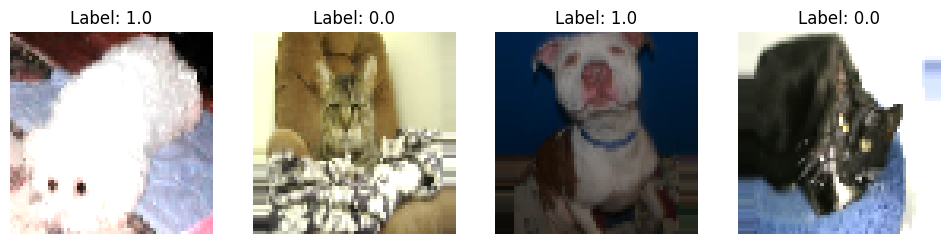

In [ ]:
images, labels = next(train_generator)

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

plt.show()

### Написание и обучение автоэнкодера

Опишем слои и методы, используемые в архитектуре автоэнкодера:

1. <code>Conv2D(n, (m, m))</code> — это слой свёрточной НС в <code>keras</code>, который применяет свёртку к входным данным, используя <code>n</code> фильтров размером <code>(m, m)</code> для извлечения признаков. Параметры: <code>activation='relu'</code> (+ нелинейность для предотвращения затухания градиента) и <code>padding='same'</code> (сохранение размерности входных данных).
2. <code>BatchNormalization</code> выравнивает активации слоев по среднему и стандартному отклонению.
3. <code>MaxPooling2D</code> выбирает максимальное значение из каждой области (например, 2x2) входных данных, уменьшая их пространственные размеры и сохраняя ключевые признаки.
4. <code>UpSampling2D</code> увеличивает размер признаковых карт, восстанавливая детали изображения после сжатия. (быстро и просто)

Получившаяся архитектура:

In [ ]:
input_image = Input(shape=(64, 64, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_image, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,419 (298.51 KB)

 Trainable params: 76,035 (297.01 KB)

 Non-trainable params: 384 (1.50 KB)

Обучаем:

In [ ]:
history_autoencoder = autoencoder.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 102s 149ms/step - loss: 0.5432 - val_loss: 0.5211
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 133ms/step - loss: 0.5210 - val_loss: 0.5223
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 131ms/step - loss: 0.5180 - val_loss: 0.5190
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 138ms/step - loss: 0.5202 - val_loss: 0.5196
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 136ms/step - loss: 0.5163 - val_loss: 0.5170
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 133ms/step - loss: 0.5152 - val_loss: 0.5178
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 131ms/step - loss: 0.5159 - val_loss: 0.5201
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - loss: 0.5162 - val_loss: 0.5172
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - loss: 0.5154 - val_loss: 0.5164
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 139ms/step - loss: 0.5165 - val_loss: 0.5125


Вывод изначальных фотографий + полученных после прохождения через автоэнкодер:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


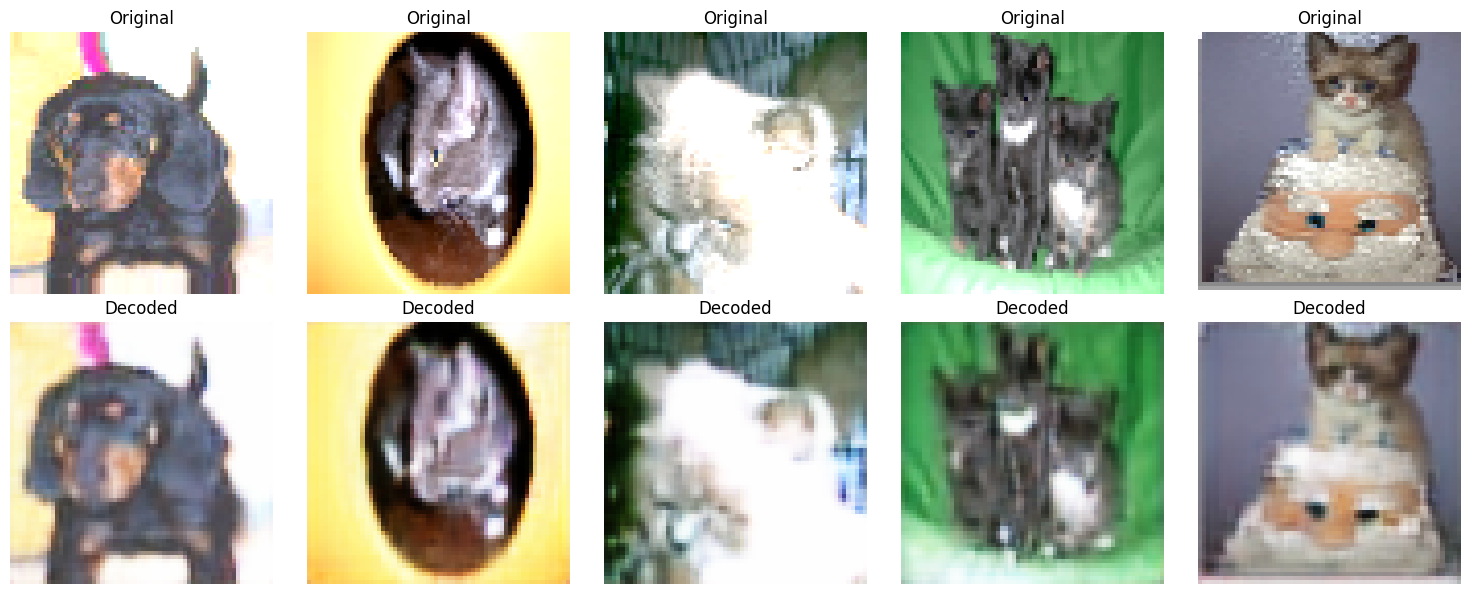

In [ ]:
def display_images(original, decoded, n=5):
    plt.figure(figsize=(n * 3, 6))
    for i in range(n):
        # Оригинал
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        ax.axis('off')
        ax.set_title("Original")
        # Восстановленные
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded[i])
        ax.axis('off')
        ax.set_title("Decoded")
    plt.tight_layout()
    plt.show()

sample_images, _ = next(validation_generator)
decoded_images = autoencoder.predict(sample_images)
display_images(sample_images, decoded_images)


### Определение и обучение классификатора

Создадим модель энкодера на основе предыдущей модели + заморозим все веса энкодера:

In [ ]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=5).output)
encoder.trainable = False
encoded_input = encoder.output

Опишем слои и методы, используемые в архитектуре классификатора:
1. <code>Dropout</code> — метод регуляризации, который случайным образом обнуляет часть нейронов с заданной вероятностью (p) во время обучения, при этом снижая риск переобучения.
2. Слой <code>Flatten</code> превращает многомерный тензор в одномерный вектор, сохраняя все значения без изменений.
3. Слой <code>Dense</code> — стандартный полносвязный слой в НС.

Получившаяся архитектура (после добавления полносвязных слоев):

In [ ]:
x = Flatten()(encoded_input)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# Выходной слой + sigmoid, так как решаем задачу бинарной классификации
output = Dense(1, activation='sigmoid')(x)

classifier = Model(inputs=encoder.input, outputs=output)
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,417,601 (32.11 MB)

 Trainable params: 8,397,441 (32.03 MB)

 Non-trainable params: 20,160 (78.75 KB)

Обучаем:

In [ ]:
history_classifier = classifier.fit(
    train_generator,
    epochs=30,
    batch_size=batch_size,
    validation_data=validation_generator)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 127ms/step - accuracy: 0.5481 - loss: 0.8205 - val_accuracy: 0.6547 - val_loss: 0.6204
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 119ms/step - accuracy: 0.6225 - loss: 0.6504 - val_accuracy: 0.6689 - val_loss: 0.6048
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 121ms/step - accuracy: 0.6500 - loss: 0.6240 - val_accuracy: 0.6805 - val_loss: 0.6000
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.6614 - loss: 0.6163 - val_accuracy: 0.6795 - val_loss: 0.5968
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 122ms/step - accuracy: 0.6590 - loss: 0.6142 - val_accuracy: 0.6813 - val_loss: 0.5911
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.6720 - loss: 0.6050 - val_accuracy: 0.6835 - val_loss: 0.5822
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 132ms/step - accuracy: 0.6717 - loss: 0.5997 - val_accuracy: 0.6881 - val_loss: 0.5861
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 136s 122ms/step - accuracy: 0.6761 - loss: 

Графики обучения нейросетей содержащие информацию о loss, accuracy:

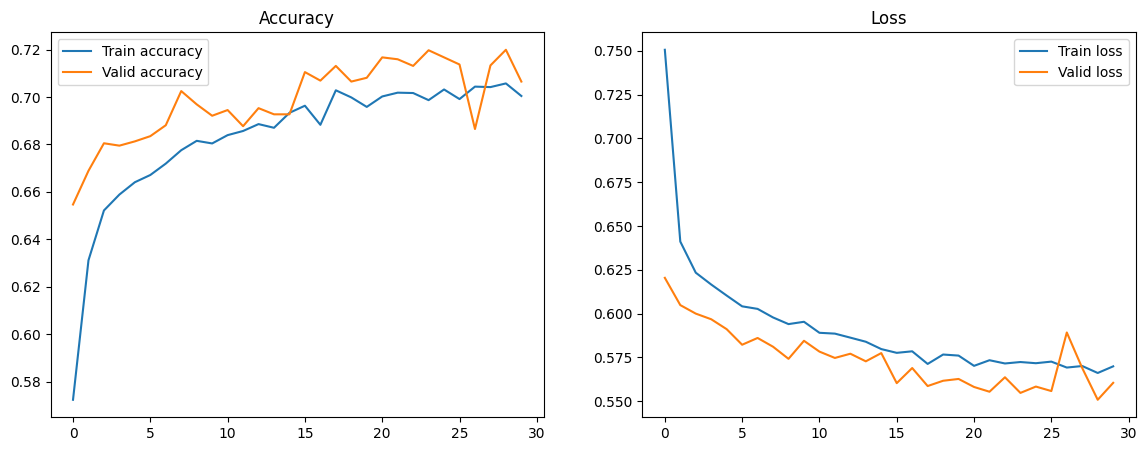

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train accuracy')
    plt.plot(epochs, val_acc, label='Valid accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train loss')
    plt.plot(epochs, val_loss, label='Valid loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history_classifier)

Некоторое количество фотографий + реальный (True) и предсказанные (Pred) финальной нейросетью классы:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


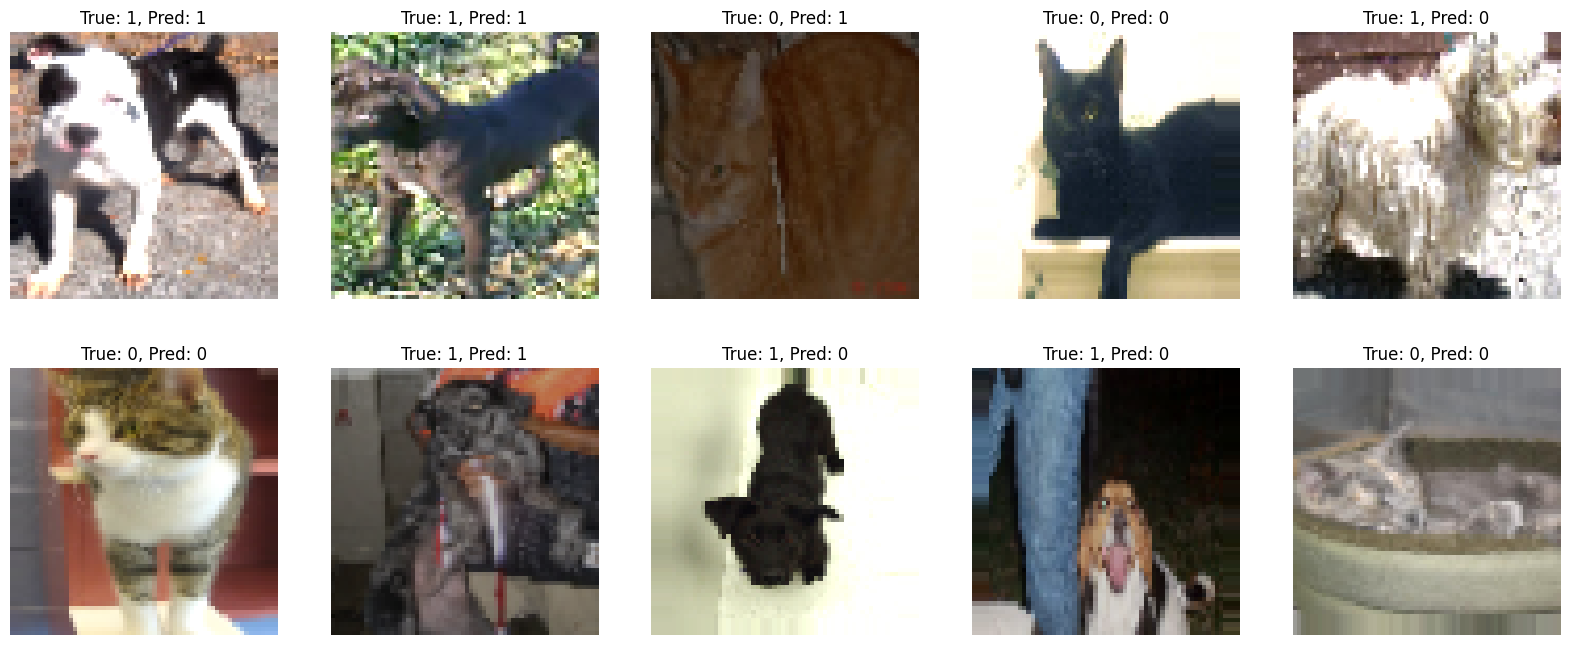

In [ ]:
def display_pred(generator, model, n=10):
    sample_images, sample_labels = next(generator)
    pred = model.predict(sample_images)
    plt.figure(figsize=(20, 8))
    for i in range(n):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(sample_images[i])
        ax.axis('off')
        ax.set_title(f"True: {int(sample_labels[i])}, Pred: {int(pred[i] > 0.5)}")
    plt.show()

display_pred(validation_generator, classifier, n=10)

Вывод: После 15-й эпохи рост accuracy замедляется, но модель продолжает немного улучшаться. В конце обучения виден небольшой скачок валидационных потерь, что может быть признаком начального переобучения или шумовых данных. В целом считаем результат приемлемым, но можно попробовать увеличить число эпох, поработать с данными на этапе обработки -- попробовать другие варианты аугментации.